In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper

from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
'''
These 2 parameters define the range of waveform we'd like to analyze
'''
LSPAN = 200 # number of time samples prior to t0
HSPAN = 755 # number of time samples after t0

In [3]:
#This function gets the false positive rate, true positive rate, cutting threshold and area under curve using the given signal and background array
# def get_roc(sig,bkg):
#     testY = np.array([1]*len(sig) + [0]*len(bkg))
#     predY = np.array(sig+bkg)
#     auc = roc_auc_score(testY, predY)
#     fpr, tpr, thr = roc_curve(testY, predY)
#     return fpr,tpr,thr,auc

In [4]:
def loadwf(filename):
    dset=np.load(filename)
    return (dset["train"],dset["train_label"]),(dset["test"],dset["test_label"])

#extract the waveforms from the simulation file:shift range and labeling provided (1 for pileup), and save waveforms to a new file
def wf_extract(sft, label):
    filename = "pileup-sims-0-" + str(sft) + ".npz"
    (x_train,y_train),(x_test,y_test)=loadwf(filename)
    #normalizing the waveform incase if they were not normalized
    train_x = np.array([x_train[i]/np.max(x_train[i]) for i in range(len(x_train))])
    test_x = np.array([x_test[i]/np.max(x_test[i]) for i in range(len(x_test))])

    #labeling of the waveform
    train_y = y_train
    test_y = y_test
    if label ==1:# finding the pileup waveform
        nwftrain =  np.argwhere(train_y == 1)
        nwftest = np.argwhere(test_y == 1)
    
    elif label ==0: # finding the NOpileup waveform
        nwftrain =  np.argwhere(train_y == 0)
        nwftest = np.argwhere(test_y == 0)
        
    else:
        print("please provide the labeling number 1 or 0: 1 for pileup waveform, and 0 for NoPileup waveform")
        
    l = np.array([nwftrain[i][0] for i in range(len(nwftrain))]) 
    nwftrain_x = np.array([train_x[l[i]] for i in range(len(l))])

    l1 = np.array([nwftest[i][0] for i in range(len(nwftest))])
    nwftest_x = np.array([test_x[l1[i]] for i in range(len(l1))])
    nwf_x = np.concatenate((nwftest_x,nwftrain_x),axis = 0)
    count = len(nwf_x)
    event_dict={}
    if label == 1:
        file_name = "PILEUP_"+str(sft)+".pickle"
        with open(file_name, 'wb') as handle:
            for i in range(count):  
                nwf=nwf_x[i]
                event_dict = {"wf":nwf}
                pickle.dump(event_dict,handle, protocol=pickle.HIGHEST_PROTOCOL)
    elif label ==0:
        file_name="NOPILEUP_"+str(sft)+".pickle"
        with open(file_name, 'wb') as handle:
            for i in range(count):  
                nwf=nwf_x[i]
                event_dict = {"wf":nwf}
                pickle.dump(event_dict,handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [5]:
class DetectorDataset(Dataset):
    
    def __init__(self, sft, dsize=-1):
        self.sft=sft
        dep = "NOPILEUP_"+str(sft)+".pickle"
        sep = "PILEUP_"+str(sft)+".pickle"
        DEP_dict = self.event_loader(dep)
        SEP_dict = self.event_loader(sep)

        if dsize == -1:
            dsize = min(len(DEP_dict), len(SEP_dict))
        
        #Shuffle dataset and select #dsize event from DEP and SEP
        np.random.shuffle(DEP_dict)
        np.random.shuffle(SEP_dict)
        DEP_dict = DEP_dict[:dsize]
        SEP_dict = SEP_dict[:dsize]
        self.event_dict = DEP_dict + SEP_dict
        self.label = ([1]*len(DEP_dict)) + ([0] * len(SEP_dict))
#         print(len(self.event_dict))
#         print(len(self.label))
        
        self.size = len(self.event_dict)
#         print(self.size)
        
    def __len__(self):
        return self.size
    
    def build_scaler(self):
        '''
        '''
        wf_array = []
        for i in range(self.size):
            wf_array.append(self.get_wf(i).reshape(1,-1))
        wf_array = np.concatenate(wf_array,axis=0)
        scaler = StandardScaler()
        scaler.fit(wf_array)
        return scaler
    
    def get_scaler(self):
        return self.scaler
    
    def set_scaler(self,scaler):
        self.scaler = scaler
    
    def get_wf(self,idx):
        event = self.event_dict[idx]
        wf = np.array(event["wf"]).flatten()
        midindex = 200

        #baseline subtraction
        wf -= np.average(wf[:(midindex-50)])
        
        #Extract waveform from its t0
        wfbegin = midindex - LSPAN
        wfend = midindex + HSPAN
        
        wf = wf[wfbegin:wfend]
        wf = (wf - np.min(wf)) / (np.max(wf) - np.min(wf))#rescale wf to between 0 and 1      
        return wf

    def __getitem__(self, idx):
        event = self.event_dict[idx]
        wf = np.array(event["wf"]).flatten()
        midindex = 200
        wf = self.get_wf(idx)
        wf = torch.from_numpy(wf).float() 
        
        return wf, self.label[idx]
    
#     def return_label(self):
#         return self.trainY
    
    #Load event from .pickle file
    def event_loader(self, address):
        wf_list = []
        with (open(address, "rb")) as openfile:
            while True:
#                 if len(wf_list) > 2000:
#                     break
                try:
                   wf_list.append(pickle.load(openfile, encoding='latin1'))
                except EOFError:
                    break
        return wf_list
    
    def get_field_from_dict(self, input_dict, fieldname):
        field_list = []
        for event in input_dict:
            field_list.append(event[fieldname])
        return field_list
    
    def plot_offset_correction(self):
        plt.subplot(211)
        
        plt.subplot(212)
# next(iter(DetectorDataset()))

In [6]:
#Load dataset
def load_data(batch_size,sft):
    dataset = DetectorDataset(sft)
    validation_split = .3 #Split data set into training & testing with 7:3 ratio
    shuffle_dataset = True
    random_seed= 12843

    #make sure we have the same amount of signal/bkg in the training/test dataset
    division = 2
    dataset_size = int(len(dataset)/division)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_indices += list(division*dataset_size - 1-np.array(train_indices))
    val_indices += list(division*dataset_size- 1-np.array(val_indices))

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=batch_size,sampler=valid_sampler,  drop_last=True)

    return train_loader,test_loader

In [7]:
# The fully connected part of neural network
class FCNet(nn.Module):
    def __init__(self, last_unit):
        super(FCNet, self).__init__()
        
        fc1, fc2, fc3, fc4 = (2640, 256, 96, 32)
        self.fcnet = nn.Sequential(
            torch.nn.Linear(fc1, fc2),
            torch.nn.BatchNorm1d(fc2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc2, fc3),
            torch.nn.BatchNorm1d(fc3),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc3, fc4),
            torch.nn.BatchNorm1d(fc4),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc4, last_unit),
        )
    def forward(self, x):
        return self.fcnet(x)

In [8]:
#The CNN based model:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
    
        conv1, conv2, conv3, conv4 = (16,24,32,48)
        self.fcnet = FCNet(1)
        self.CNNBackbone = nn.Sequential(
            torch.nn.Conv1d(1,conv1,16),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.BatchNorm1d(conv1),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Conv1d(conv1,conv2,8),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.BatchNorm1d(conv2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Conv1d(conv2,conv3,4),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.BatchNorm1d(conv3),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Conv1d(conv3,conv4,4),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.BatchNorm1d(conv4),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout()
        )
    
#     @torchsnooper.snoop()
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.CNNBackbone(x)
        x = x.view(x.size(0),-1)
# #         x = torch.relu(x)
        x = self.fcnet(x)
        return x

In [9]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__() 
#         self.feature_extrator = nn.Sequential(
# #             nn.Conv2d(1,5,3,1,3),     
# #             nn.BatchNorm2d(5),     
# #             torch.nn.LeakyReLU(),  
# #             nn.MaxPool2d(2),  
            
#         nn.Conv1d(1,25,3,1,3), 
#         nn.MaxPool1d(2),
#         nn.BatchNorm1d(25),     
#         torch.nn.LeakyReLU(),  
        

#         nn.Conv1d(25,15,3,1,3), 
#         nn.MaxPool1d(2),
#         nn.BatchNorm1d(15),     
#         torch.nn.LeakyReLU(),  
       

#         nn.Conv1d(15,10,3,1,3),
#         nn.MaxPool1d(2),
#         nn.BatchNorm1d(10),     
#         torch.nn.LeakyReLU(),  
        

#         nn.Conv1d(10,5,3,1,3), 
#         nn.MaxPool1d(2),  
#         nn.BatchNorm1d(5),     
#         torch.nn.LeakyReLU(),  
        
#         )
        
#         self.fc_classifier = nn.Sequential(
#             nn.Linear(3750,1)
# #             nn.Sigmoid()
#         )
#     @torchsnooper.snoop()
#     def forward(self, x):
#         batch_size = x.size(0)        # Read the input batch size 
#         x = x.unsqueeze(1)
# #         x = x.unsqueeze(1) 
#         x = self.feature_extrator(x)  # Feature extraction
#         x = x.view(batch_size, -1)    # Flatten the output feature map into a 1D feature vector
#         x = self.fc_classifier(x)    
#         return x

In [10]:
BATCH_SIZE = 40
sft = 300
train_loader, test_loader = load_data(BATCH_SIZE,sft)

In [11]:
def get_sigmoid(waveform_in, labels_in ,classifier_in):
    waveform_in = waveform_in.to(DEVICE)
    labels_in = labels_in.to(DEVICE).float()
    outputs_in = classifier_in(waveform_in)

    lb_data_in = labels_in.cpu().data.numpy().flatten()
    outpt_data_in = outputs_in.cpu().data.numpy().flatten()

    signal_in = np.argwhere(lb_data_in == 1.0)
    bkg_in = np.argwhere(lb_data_in == 0.0)

    return list(outpt_data_in[signal_in].flatten()), list(outpt_data_in[bkg_in].flatten())

In [12]:
def run_wf_in_nn(sft):
    
    train_loader, test_loader = load_data(BATCH_SIZE,sft)
    #Define CNN network
    CNNclassifier = CNN()

    CNNclassifier.to(DEVICE)

    print("#params", sum(x.numel() for x in CNNclassifier.parameters()))

    CNNcriterion = torch.nn.BCEWithLogitsLoss() #BCEWithLogitsLoss does not require the last layer to be sigmoid
    CNNcriterion = CNNcriterion.to(DEVICE)
    warmup_size = 4000
    lmbda = lambda epoch: min((epoch+1)**-0.5, (epoch+1)*warmup_size**-1.5)
    CNNoptimizer = torch.optim.AdamW(CNNclassifier.parameters(),lr=LEARNING_RATE, betas=(0.9, 0.98),eps=1e-9)
#     CNNoptimizer = torch.optim.SGD(CNNclassifier.parameters(),lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.LambdaLR(CNNoptimizer, lr_lambda=lmbda)

    for epoch in range(NUM_EPOCHS):
        for i, (waveform, labels) in enumerate(train_loader):
            CNNclassifier.train()
            waveform = waveform.to(DEVICE)
            labels = labels.to(DEVICE).float()
            labels = labels.view(-1,1)

            #Train CNN
            CNNoutputs  = CNNclassifier(waveform)
            CNNloss = CNNcriterion(CNNoutputs, labels)
            
            CNNloss.backward()
            CNNoptimizer.step()        # update parameters of net
            CNNoptimizer.zero_grad()   # reset gradient
            scheduler.step()
#         print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(epoch+1, NUM_EPOCHS, i+1, len(train_loader),RNNloss.item(), end=""),end="")
        sigmoid_s_CNN = []
        sigmoid_b_CNN = []

        for waveform,labels in tqdm.tqdm(test_loader):

            CNNclassifier.eval()
            
            with torch.no_grad():
                sig_CNN, bkg_CNN = get_sigmoid(waveform, labels, CNNclassifier)

                lb_data = labels.cpu().data.numpy().flatten()

                signal = np.argwhere(lb_data == 1.0)
                bkg = np.argwhere(lb_data == 0.0)

                sigmoid_s_CNN += sig_CNN
                sigmoid_b_CNN += bkg_CNN
    f = np.savez("cnn_sigoutput", output = sigmoid_s_CNN)
    g = np.savez("cnn_bkgoutput", output = sigmoid_b_CNN)
        

Shift:   0%|          | 0/20 [00:00<?, ?it/s]

#params 717577


/home/usd.local/laxman.paudel/miniconda3/envs/pytorchtest/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)

100%|██████████| 75/75 [00:00<00:00, 280.09it/s]

100%|██████████| 75/75 [00:00<00:00, 293.59it/s]

100%|██████████| 75/75 [00:00<00:00, 291.32it/s]

100%|██████████| 75/75 [00:00<00:00, 290.75it/s]

100%|██████████| 75/75 [00:00<00:00, 292.27it/s]

100%|██████████| 75/75 [00:00<00:00, 293.32it/s]

100%|██████████| 75/75 [00:00<00:00, 293.62it/s]

100%|██████████| 75/75 [00:00<00:00, 292.57it/s]

100%|██████████| 75/75 [00:00<00:00, 287.54it/s]

100%|██████████| 75/75 [00:00<00:00, 287.71it/s]

100%|████

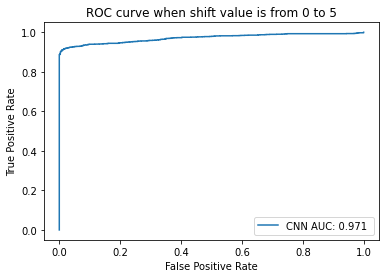

#params 717577



100%|██████████| 75/75 [00:00<00:00, 292.76it/s]

100%|██████████| 75/75 [00:00<00:00, 293.48it/s]

100%|██████████| 75/75 [00:00<00:00, 293.33it/s]

100%|██████████| 75/75 [00:00<00:00, 292.67it/s]

100%|██████████| 75/75 [00:00<00:00, 292.49it/s]

100%|██████████| 75/75 [00:00<00:00, 292.50it/s]

100%|██████████| 75/75 [00:00<00:00, 293.21it/s]

100%|██████████| 75/75 [00:00<00:00, 294.23it/s]

100%|██████████| 75/75 [00:00<00:00, 294.46it/s]

100%|██████████| 75/75 [00:00<00:00, 289.83it/s]

100%|██████████| 75/75 [00:00<00:00, 291.33it/s]

100%|██████████| 75/75 [00:00<00:00, 282.04it/s]

100%|██████████| 75/75 [00:00<00:00, 293.31it/s]

100%|██████████| 75/75 [00:00<00:00, 293.83it/s]

100%|██████████| 75/75 [00:00<00:00, 293.40it/s]

100%|██████████| 75/75 [00:00<00:00, 293.96it/s]

100%|██████████| 75/75 [00:00<00:00, 293.67it/s]

100%|██████████| 75/75 [00:00<00:00, 293.60it/s]

100%|██████████| 75/75 [00:00<00:00, 292.83it/s]

100%|██████████| 75/75 [00:00<00:00, 293.72it/s]


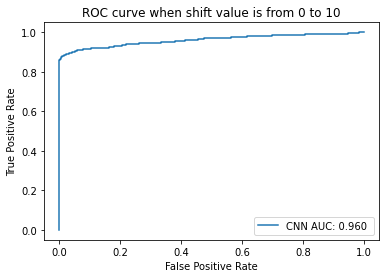

#params 717577



100%|██████████| 75/75 [00:00<00:00, 295.69it/s]

100%|██████████| 75/75 [00:00<00:00, 294.88it/s]

100%|██████████| 75/75 [00:00<00:00, 294.08it/s]

100%|██████████| 75/75 [00:00<00:00, 294.92it/s]

100%|██████████| 75/75 [00:00<00:00, 295.17it/s]

100%|██████████| 75/75 [00:00<00:00, 292.42it/s]

100%|██████████| 75/75 [00:00<00:00, 295.73it/s]

100%|██████████| 75/75 [00:00<00:00, 295.09it/s]

100%|██████████| 75/75 [00:00<00:00, 295.87it/s]

100%|██████████| 75/75 [00:00<00:00, 295.00it/s]

100%|██████████| 75/75 [00:00<00:00, 296.07it/s]

100%|██████████| 75/75 [00:00<00:00, 294.98it/s]

100%|██████████| 75/75 [00:00<00:00, 295.31it/s]

100%|██████████| 75/75 [00:00<00:00, 295.36it/s]

100%|██████████| 75/75 [00:00<00:00, 295.41it/s]

100%|██████████| 75/75 [00:00<00:00, 295.12it/s]

100%|██████████| 75/75 [00:00<00:00, 294.14it/s]

100%|██████████| 75/75 [00:00<00:00, 293.98it/s]

100%|██████████| 75/75 [00:00<00:00, 294.61it/s]

100%|██████████| 75/75 [00:00<00:00, 295.29it/s]


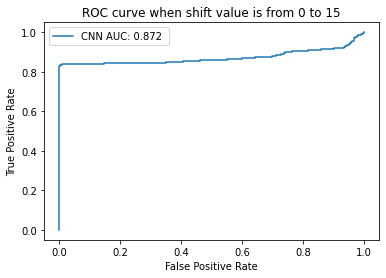

#params 717577



100%|██████████| 75/75 [00:00<00:00, 293.95it/s]

100%|██████████| 75/75 [00:00<00:00, 293.17it/s]

100%|██████████| 75/75 [00:00<00:00, 294.06it/s]

100%|██████████| 75/75 [00:00<00:00, 293.95it/s]

100%|██████████| 75/75 [00:00<00:00, 291.51it/s]

100%|██████████| 75/75 [00:00<00:00, 293.34it/s]

100%|██████████| 75/75 [00:00<00:00, 294.77it/s]

100%|██████████| 75/75 [00:00<00:00, 294.66it/s]

100%|██████████| 75/75 [00:00<00:00, 293.44it/s]

100%|██████████| 75/75 [00:00<00:00, 295.03it/s]

100%|██████████| 75/75 [00:00<00:00, 295.09it/s]

100%|██████████| 75/75 [00:00<00:00, 294.68it/s]

100%|██████████| 75/75 [00:00<00:00, 295.72it/s]

100%|██████████| 75/75 [00:00<00:00, 294.91it/s]

100%|██████████| 75/75 [00:00<00:00, 295.52it/s]

100%|██████████| 75/75 [00:00<00:00, 293.98it/s]

100%|██████████| 75/75 [00:00<00:00, 295.60it/s]

100%|██████████| 75/75 [00:00<00:00, 294.69it/s]

100%|██████████| 75/75 [00:00<00:00, 295.84it/s]

100%|██████████| 75/75 [00:00<00:00, 294.01it/s]


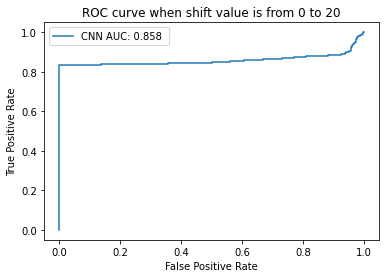

#params 717577



100%|██████████| 75/75 [00:00<00:00, 295.30it/s]

100%|██████████| 75/75 [00:00<00:00, 294.13it/s]

100%|██████████| 75/75 [00:00<00:00, 295.29it/s]

100%|██████████| 75/75 [00:00<00:00, 294.92it/s]

100%|██████████| 75/75 [00:00<00:00, 292.85it/s]

100%|██████████| 75/75 [00:00<00:00, 294.09it/s]

100%|██████████| 75/75 [00:00<00:00, 293.32it/s]

100%|██████████| 75/75 [00:00<00:00, 294.37it/s]

100%|██████████| 75/75 [00:00<00:00, 292.02it/s]

100%|██████████| 75/75 [00:00<00:00, 294.81it/s]

100%|██████████| 75/75 [00:00<00:00, 294.13it/s]

100%|██████████| 75/75 [00:00<00:00, 294.22it/s]

100%|██████████| 75/75 [00:00<00:00, 292.39it/s]

100%|██████████| 75/75 [00:00<00:00, 294.74it/s]

100%|██████████| 75/75 [00:00<00:00, 294.54it/s]

100%|██████████| 75/75 [00:00<00:00, 293.77it/s]

100%|██████████| 75/75 [00:00<00:00, 294.45it/s]

100%|██████████| 75/75 [00:00<00:00, 234.39it/s]

100%|██████████| 75/75 [00:00<00:00, 294.74it/s]

100%|██████████| 75/75 [00:00<00:00, 294.79it/s]


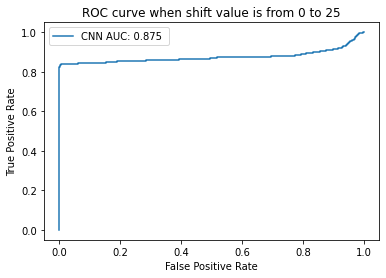

#params 717577



100%|██████████| 75/75 [00:00<00:00, 290.87it/s]

100%|██████████| 75/75 [00:00<00:00, 293.98it/s]

100%|██████████| 75/75 [00:00<00:00, 294.18it/s]

100%|██████████| 75/75 [00:00<00:00, 294.43it/s]

100%|██████████| 75/75 [00:00<00:00, 294.01it/s]

100%|██████████| 75/75 [00:00<00:00, 294.78it/s]

100%|██████████| 75/75 [00:00<00:00, 293.36it/s]

100%|██████████| 75/75 [00:00<00:00, 293.89it/s]

100%|██████████| 75/75 [00:00<00:00, 292.42it/s]

100%|██████████| 75/75 [00:00<00:00, 294.17it/s]

100%|██████████| 75/75 [00:00<00:00, 293.84it/s]

100%|██████████| 75/75 [00:00<00:00, 293.63it/s]

100%|██████████| 75/75 [00:00<00:00, 293.96it/s]

100%|██████████| 75/75 [00:00<00:00, 293.52it/s]

100%|██████████| 75/75 [00:00<00:00, 292.95it/s]

100%|██████████| 75/75 [00:00<00:00, 292.89it/s]

100%|██████████| 75/75 [00:00<00:00, 294.29it/s]

100%|██████████| 75/75 [00:00<00:00, 292.63it/s]

100%|██████████| 75/75 [00:00<00:00, 293.85it/s]

100%|██████████| 75/75 [00:00<00:00, 292.70it/s]


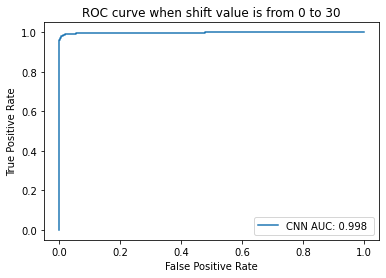

#params 717577



100%|██████████| 75/75 [00:00<00:00, 293.86it/s]

100%|██████████| 75/75 [00:00<00:00, 294.65it/s]

100%|██████████| 75/75 [00:00<00:00, 294.41it/s]

100%|██████████| 75/75 [00:00<00:00, 293.01it/s]

100%|██████████| 75/75 [00:00<00:00, 293.07it/s]

100%|██████████| 75/75 [00:00<00:00, 293.76it/s]

100%|██████████| 75/75 [00:00<00:00, 291.34it/s]

100%|██████████| 75/75 [00:00<00:00, 292.34it/s]

100%|██████████| 75/75 [00:00<00:00, 292.76it/s]

100%|██████████| 75/75 [00:00<00:00, 293.52it/s]

100%|██████████| 75/75 [00:00<00:00, 286.55it/s]

100%|██████████| 75/75 [00:00<00:00, 293.58it/s]

100%|██████████| 75/75 [00:00<00:00, 294.32it/s]

100%|██████████| 75/75 [00:00<00:00, 293.63it/s]

100%|██████████| 75/75 [00:00<00:00, 293.87it/s]

100%|██████████| 75/75 [00:00<00:00, 293.55it/s]

100%|██████████| 75/75 [00:00<00:00, 294.28it/s]

100%|██████████| 75/75 [00:00<00:00, 294.33it/s]

100%|██████████| 75/75 [00:00<00:00, 293.84it/s]

100%|██████████| 75/75 [00:00<00:00, 294.75it/s]


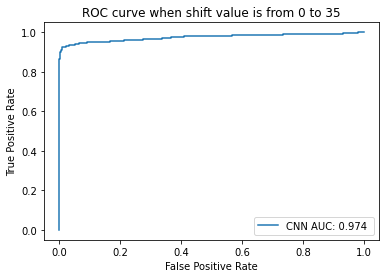

#params 717577



100%|██████████| 75/75 [00:00<00:00, 255.88it/s]

100%|██████████| 75/75 [00:00<00:00, 292.07it/s]

100%|██████████| 75/75 [00:00<00:00, 292.18it/s]

100%|██████████| 75/75 [00:00<00:00, 292.97it/s]

100%|██████████| 75/75 [00:00<00:00, 292.76it/s]

100%|██████████| 75/75 [00:00<00:00, 290.98it/s]

100%|██████████| 75/75 [00:00<00:00, 294.03it/s]

100%|██████████| 75/75 [00:00<00:00, 293.71it/s]

100%|██████████| 75/75 [00:00<00:00, 292.89it/s]

100%|██████████| 75/75 [00:00<00:00, 293.30it/s]

100%|██████████| 75/75 [00:00<00:00, 292.72it/s]

100%|██████████| 75/75 [00:00<00:00, 292.91it/s]

100%|██████████| 75/75 [00:00<00:00, 293.69it/s]

100%|██████████| 75/75 [00:00<00:00, 291.96it/s]

100%|██████████| 75/75 [00:00<00:00, 292.24it/s]

100%|██████████| 75/75 [00:00<00:00, 292.89it/s]

100%|██████████| 75/75 [00:00<00:00, 291.74it/s]

100%|██████████| 75/75 [00:00<00:00, 293.44it/s]

100%|██████████| 75/75 [00:00<00:00, 292.23it/s]

100%|██████████| 75/75 [00:00<00:00, 293.13it/s]


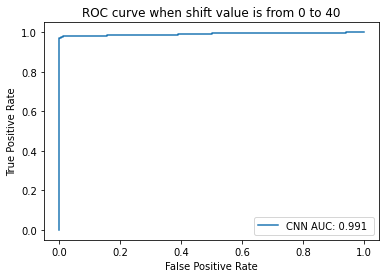

#params 717577



100%|██████████| 75/75 [00:00<00:00, 294.69it/s]

100%|██████████| 75/75 [00:00<00:00, 291.01it/s]

100%|██████████| 75/75 [00:00<00:00, 294.88it/s]

100%|██████████| 75/75 [00:00<00:00, 292.31it/s]

100%|██████████| 75/75 [00:00<00:00, 294.78it/s]

100%|██████████| 75/75 [00:00<00:00, 292.36it/s]

100%|██████████| 75/75 [00:00<00:00, 294.32it/s]

100%|██████████| 75/75 [00:00<00:00, 293.38it/s]

100%|██████████| 75/75 [00:00<00:00, 293.73it/s]

100%|██████████| 75/75 [00:00<00:00, 293.93it/s]

100%|██████████| 75/75 [00:00<00:00, 294.09it/s]

100%|██████████| 75/75 [00:00<00:00, 294.48it/s]

100%|██████████| 75/75 [00:00<00:00, 292.92it/s]

100%|██████████| 75/75 [00:00<00:00, 294.22it/s]

100%|██████████| 75/75 [00:00<00:00, 293.39it/s]

100%|██████████| 75/75 [00:00<00:00, 293.98it/s]

100%|██████████| 75/75 [00:00<00:00, 293.81it/s]

100%|██████████| 75/75 [00:00<00:00, 234.24it/s]

100%|██████████| 75/75 [00:00<00:00, 293.99it/s]

100%|██████████| 75/75 [00:00<00:00, 293.74it/s]


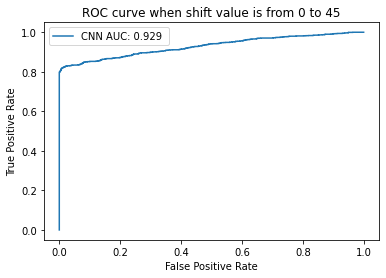

#params 717577



100%|██████████| 75/75 [00:00<00:00, 292.58it/s]

100%|██████████| 75/75 [00:00<00:00, 292.92it/s]

100%|██████████| 75/75 [00:00<00:00, 293.42it/s]

100%|██████████| 75/75 [00:00<00:00, 293.98it/s]

100%|██████████| 75/75 [00:00<00:00, 292.54it/s]

100%|██████████| 75/75 [00:00<00:00, 293.51it/s]

100%|██████████| 75/75 [00:00<00:00, 291.12it/s]

100%|██████████| 75/75 [00:00<00:00, 291.91it/s]

100%|██████████| 75/75 [00:00<00:00, 290.92it/s]

100%|██████████| 75/75 [00:00<00:00, 293.07it/s]

100%|██████████| 75/75 [00:00<00:00, 293.63it/s]

100%|██████████| 75/75 [00:00<00:00, 292.60it/s]

100%|██████████| 75/75 [00:00<00:00, 293.21it/s]

100%|██████████| 75/75 [00:00<00:00, 293.62it/s]

100%|██████████| 75/75 [00:00<00:00, 293.34it/s]

100%|██████████| 75/75 [00:00<00:00, 292.57it/s]

100%|██████████| 75/75 [00:00<00:00, 293.37it/s]

100%|██████████| 75/75 [00:00<00:00, 293.89it/s]

100%|██████████| 75/75 [00:00<00:00, 293.83it/s]

100%|██████████| 75/75 [00:00<00:00, 292.69it/s]


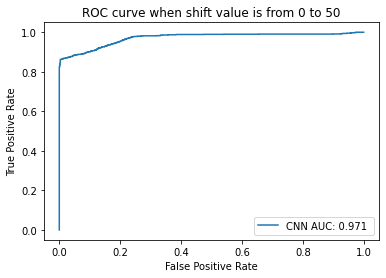

#params 717577



100%|██████████| 75/75 [00:00<00:00, 292.82it/s]

100%|██████████| 75/75 [00:00<00:00, 294.53it/s]

100%|██████████| 75/75 [00:00<00:00, 293.66it/s]

100%|██████████| 75/75 [00:00<00:00, 288.88it/s]

100%|██████████| 75/75 [00:00<00:00, 292.74it/s]

100%|██████████| 75/75 [00:00<00:00, 292.84it/s]

100%|██████████| 75/75 [00:00<00:00, 293.48it/s]

100%|██████████| 75/75 [00:00<00:00, 292.87it/s]

100%|██████████| 75/75 [00:00<00:00, 293.44it/s]

100%|██████████| 75/75 [00:00<00:00, 294.47it/s]

100%|██████████| 75/75 [00:00<00:00, 291.85it/s]

100%|██████████| 75/75 [00:00<00:00, 293.74it/s]

100%|██████████| 75/75 [00:00<00:00, 293.37it/s]

100%|██████████| 75/75 [00:00<00:00, 293.55it/s]

100%|██████████| 75/75 [00:00<00:00, 288.11it/s]

100%|██████████| 75/75 [00:00<00:00, 292.55it/s]

100%|██████████| 75/75 [00:00<00:00, 293.10it/s]

100%|██████████| 75/75 [00:00<00:00, 293.54it/s]

100%|██████████| 75/75 [00:00<00:00, 293.30it/s]

100%|██████████| 75/75 [00:00<00:00, 292.79it/s]


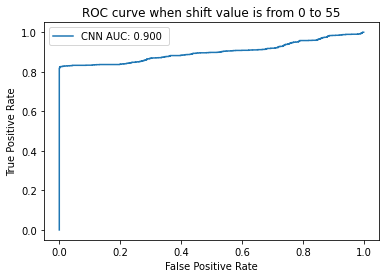

#params 717577



100%|██████████| 75/75 [00:00<00:00, 292.74it/s]

100%|██████████| 75/75 [00:00<00:00, 291.39it/s]

100%|██████████| 75/75 [00:00<00:00, 290.92it/s]

100%|██████████| 75/75 [00:00<00:00, 292.42it/s]

100%|██████████| 75/75 [00:00<00:00, 289.83it/s]

100%|██████████| 75/75 [00:00<00:00, 291.53it/s]

100%|██████████| 75/75 [00:00<00:00, 292.25it/s]

100%|██████████| 75/75 [00:00<00:00, 292.93it/s]

100%|██████████| 75/75 [00:00<00:00, 291.60it/s]

100%|██████████| 75/75 [00:00<00:00, 292.50it/s]

100%|██████████| 75/75 [00:00<00:00, 293.34it/s]

100%|██████████| 75/75 [00:00<00:00, 293.93it/s]

100%|██████████| 75/75 [00:00<00:00, 293.65it/s]

100%|██████████| 75/75 [00:00<00:00, 293.03it/s]

100%|██████████| 75/75 [00:00<00:00, 293.62it/s]

100%|██████████| 75/75 [00:00<00:00, 293.08it/s]

100%|██████████| 75/75 [00:00<00:00, 294.04it/s]

100%|██████████| 75/75 [00:00<00:00, 293.49it/s]

100%|██████████| 75/75 [00:00<00:00, 294.23it/s]

100%|██████████| 75/75 [00:00<00:00, 293.91it/s]


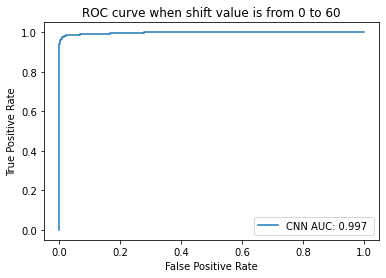

#params 717577



100%|██████████| 75/75 [00:00<00:00, 292.62it/s]

100%|██████████| 75/75 [00:00<00:00, 292.63it/s]

100%|██████████| 75/75 [00:00<00:00, 291.89it/s]

100%|██████████| 75/75 [00:00<00:00, 292.96it/s]

100%|██████████| 75/75 [00:00<00:00, 292.49it/s]

100%|██████████| 75/75 [00:00<00:00, 292.10it/s]

100%|██████████| 75/75 [00:00<00:00, 293.16it/s]

100%|██████████| 75/75 [00:00<00:00, 291.12it/s]

100%|██████████| 75/75 [00:00<00:00, 291.99it/s]

100%|██████████| 75/75 [00:00<00:00, 290.43it/s]

100%|██████████| 75/75 [00:00<00:00, 293.01it/s]

100%|██████████| 75/75 [00:00<00:00, 293.20it/s]

100%|██████████| 75/75 [00:00<00:00, 292.85it/s]

100%|██████████| 75/75 [00:00<00:00, 293.44it/s]

100%|██████████| 75/75 [00:00<00:00, 293.03it/s]

100%|██████████| 75/75 [00:00<00:00, 292.68it/s]

100%|██████████| 75/75 [00:00<00:00, 292.52it/s]

100%|██████████| 75/75 [00:00<00:00, 233.90it/s]

100%|██████████| 75/75 [00:00<00:00, 293.36it/s]

100%|██████████| 75/75 [00:00<00:00, 292.71it/s]


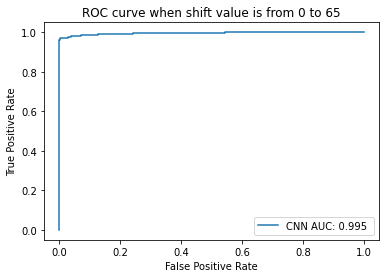

#params 717577



100%|██████████| 75/75 [00:00<00:00, 293.03it/s]

100%|██████████| 75/75 [00:00<00:00, 292.60it/s]

100%|██████████| 75/75 [00:00<00:00, 293.84it/s]

100%|██████████| 75/75 [00:00<00:00, 293.30it/s]

100%|██████████| 75/75 [00:00<00:00, 293.28it/s]

100%|██████████| 75/75 [00:00<00:00, 292.84it/s]

100%|██████████| 75/75 [00:00<00:00, 291.64it/s]

100%|██████████| 75/75 [00:00<00:00, 292.17it/s]

100%|██████████| 75/75 [00:00<00:00, 292.01it/s]

100%|██████████| 75/75 [00:00<00:00, 243.33it/s]

100%|██████████| 75/75 [00:00<00:00, 293.25it/s]

100%|██████████| 75/75 [00:00<00:00, 293.19it/s]

100%|██████████| 75/75 [00:00<00:00, 293.32it/s]

100%|██████████| 75/75 [00:00<00:00, 292.13it/s]

100%|██████████| 75/75 [00:00<00:00, 292.62it/s]

100%|██████████| 75/75 [00:00<00:00, 287.42it/s]

100%|██████████| 75/75 [00:00<00:00, 287.95it/s]

100%|██████████| 75/75 [00:00<00:00, 291.04it/s]

100%|██████████| 75/75 [00:00<00:00, 291.98it/s]

100%|██████████| 75/75 [00:00<00:00, 291.53it/s]


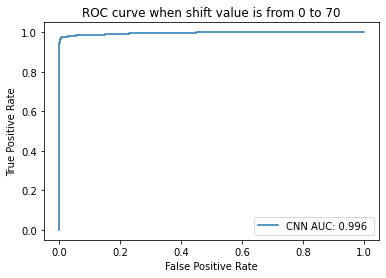

#params 717577



100%|██████████| 75/75 [00:00<00:00, 292.88it/s]

100%|██████████| 75/75 [00:00<00:00, 293.24it/s]

100%|██████████| 75/75 [00:00<00:00, 292.72it/s]

100%|██████████| 75/75 [00:00<00:00, 289.25it/s]

100%|██████████| 75/75 [00:00<00:00, 292.47it/s]

100%|██████████| 75/75 [00:00<00:00, 290.70it/s]

100%|██████████| 75/75 [00:00<00:00, 292.99it/s]

100%|██████████| 75/75 [00:00<00:00, 291.93it/s]

100%|██████████| 75/75 [00:00<00:00, 292.72it/s]

100%|██████████| 75/75 [00:00<00:00, 293.00it/s]

100%|██████████| 75/75 [00:00<00:00, 292.80it/s]

100%|██████████| 75/75 [00:00<00:00, 292.89it/s]

100%|██████████| 75/75 [00:00<00:00, 292.21it/s]

100%|██████████| 75/75 [00:00<00:00, 292.89it/s]

100%|██████████| 75/75 [00:00<00:00, 292.22it/s]

100%|██████████| 75/75 [00:00<00:00, 292.92it/s]

100%|██████████| 75/75 [00:00<00:00, 293.25it/s]

100%|██████████| 75/75 [00:00<00:00, 291.78it/s]

100%|██████████| 75/75 [00:00<00:00, 292.96it/s]

100%|██████████| 75/75 [00:00<00:00, 291.85it/s]


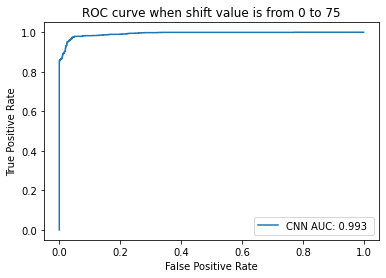

#params 717577



100%|██████████| 75/75 [00:00<00:00, 292.16it/s]

100%|██████████| 75/75 [00:00<00:00, 292.71it/s]

100%|██████████| 75/75 [00:00<00:00, 291.31it/s]

100%|██████████| 75/75 [00:00<00:00, 292.31it/s]

100%|██████████| 75/75 [00:00<00:00, 292.24it/s]

100%|██████████| 75/75 [00:00<00:00, 292.46it/s]

100%|██████████| 75/75 [00:00<00:00, 293.37it/s]

100%|██████████| 75/75 [00:00<00:00, 292.83it/s]

100%|██████████| 75/75 [00:00<00:00, 292.02it/s]

100%|██████████| 75/75 [00:00<00:00, 292.35it/s]

100%|██████████| 75/75 [00:00<00:00, 293.06it/s]

100%|██████████| 75/75 [00:00<00:00, 292.61it/s]

100%|██████████| 75/75 [00:00<00:00, 293.21it/s]

100%|██████████| 75/75 [00:00<00:00, 292.90it/s]

100%|██████████| 75/75 [00:00<00:00, 293.28it/s]

100%|██████████| 75/75 [00:00<00:00, 293.15it/s]

100%|██████████| 75/75 [00:00<00:00, 293.64it/s]

100%|██████████| 75/75 [00:00<00:00, 293.70it/s]

100%|██████████| 75/75 [00:00<00:00, 291.55it/s]

100%|██████████| 75/75 [00:00<00:00, 293.02it/s]


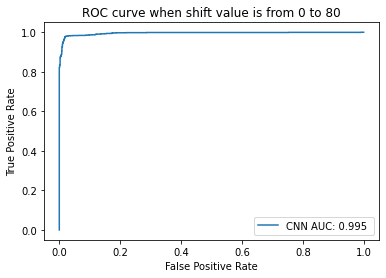

#params 717577



100%|██████████| 75/75 [00:00<00:00, 291.83it/s]

100%|██████████| 75/75 [00:00<00:00, 291.26it/s]

100%|██████████| 75/75 [00:00<00:00, 286.47it/s]

100%|██████████| 75/75 [00:00<00:00, 292.33it/s]

100%|██████████| 75/75 [00:00<00:00, 292.02it/s]

100%|██████████| 75/75 [00:00<00:00, 291.16it/s]

100%|██████████| 75/75 [00:00<00:00, 292.43it/s]

100%|██████████| 75/75 [00:00<00:00, 291.57it/s]

100%|██████████| 75/75 [00:00<00:00, 291.25it/s]

100%|██████████| 75/75 [00:00<00:00, 292.73it/s]

100%|██████████| 75/75 [00:00<00:00, 291.94it/s]

100%|██████████| 75/75 [00:00<00:00, 289.81it/s]

100%|██████████| 75/75 [00:00<00:00, 292.11it/s]

100%|██████████| 75/75 [00:00<00:00, 292.57it/s]

100%|██████████| 75/75 [00:00<00:00, 292.31it/s]

100%|██████████| 75/75 [00:00<00:00, 291.26it/s]

100%|██████████| 75/75 [00:00<00:00, 291.56it/s]

100%|██████████| 75/75 [00:00<00:00, 232.18it/s]

100%|██████████| 75/75 [00:00<00:00, 291.57it/s]

100%|██████████| 75/75 [00:00<00:00, 291.86it/s]


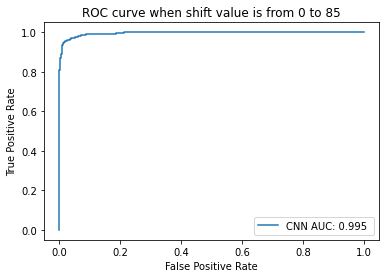

#params 717577



100%|██████████| 75/75 [00:00<00:00, 291.32it/s]

100%|██████████| 75/75 [00:00<00:00, 292.81it/s]

100%|██████████| 75/75 [00:00<00:00, 291.20it/s]

100%|██████████| 75/75 [00:00<00:00, 291.72it/s]

100%|██████████| 75/75 [00:00<00:00, 289.78it/s]

100%|██████████| 75/75 [00:00<00:00, 291.33it/s]

100%|██████████| 75/75 [00:00<00:00, 292.95it/s]

100%|██████████| 75/75 [00:00<00:00, 291.95it/s]

100%|██████████| 75/75 [00:00<00:00, 292.53it/s]

100%|██████████| 75/75 [00:00<00:00, 292.56it/s]

100%|██████████| 75/75 [00:00<00:00, 292.90it/s]

100%|██████████| 75/75 [00:00<00:00, 292.57it/s]

100%|██████████| 75/75 [00:00<00:00, 292.78it/s]

100%|██████████| 75/75 [00:00<00:00, 292.33it/s]

100%|██████████| 75/75 [00:00<00:00, 292.41it/s]

100%|██████████| 75/75 [00:00<00:00, 292.42it/s]

100%|██████████| 75/75 [00:00<00:00, 293.24it/s]

100%|██████████| 75/75 [00:00<00:00, 292.32it/s]

100%|██████████| 75/75 [00:00<00:00, 291.45it/s]

100%|██████████| 75/75 [00:00<00:00, 291.77it/s]


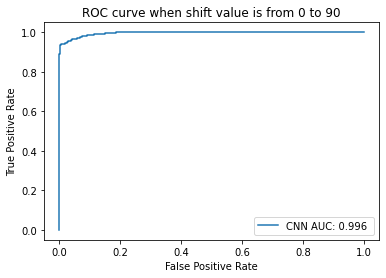

#params 717577



100%|██████████| 75/75 [00:00<00:00, 287.60it/s]

100%|██████████| 75/75 [00:00<00:00, 293.15it/s]

100%|██████████| 75/75 [00:00<00:00, 293.28it/s]

100%|██████████| 75/75 [00:00<00:00, 292.96it/s]

100%|██████████| 75/75 [00:00<00:00, 293.68it/s]

100%|██████████| 75/75 [00:00<00:00, 293.11it/s]

100%|██████████| 75/75 [00:00<00:00, 294.48it/s]

100%|██████████| 75/75 [00:00<00:00, 294.14it/s]

100%|██████████| 75/75 [00:00<00:00, 294.43it/s]

100%|██████████| 75/75 [00:00<00:00, 294.52it/s]

100%|██████████| 75/75 [00:00<00:00, 294.59it/s]

100%|██████████| 75/75 [00:00<00:00, 292.09it/s]

100%|██████████| 75/75 [00:00<00:00, 294.02it/s]

100%|██████████| 75/75 [00:00<00:00, 293.86it/s]

100%|██████████| 75/75 [00:00<00:00, 293.67it/s]

100%|██████████| 75/75 [00:00<00:00, 294.02it/s]

100%|██████████| 75/75 [00:00<00:00, 295.01it/s]

100%|██████████| 75/75 [00:00<00:00, 294.81it/s]

100%|██████████| 75/75 [00:00<00:00, 294.17it/s]

100%|██████████| 75/75 [00:00<00:00, 294.49it/s]


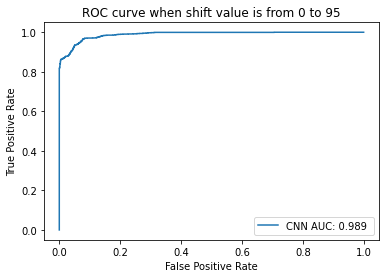

#params 717577



100%|██████████| 75/75 [00:00<00:00, 293.11it/s]

100%|██████████| 75/75 [00:00<00:00, 293.76it/s]

100%|██████████| 75/75 [00:00<00:00, 294.85it/s]

100%|██████████| 75/75 [00:00<00:00, 294.68it/s]

100%|██████████| 75/75 [00:00<00:00, 295.31it/s]

100%|██████████| 75/75 [00:00<00:00, 294.45it/s]

100%|██████████| 75/75 [00:00<00:00, 295.54it/s]

100%|██████████| 75/75 [00:00<00:00, 293.79it/s]

100%|██████████| 75/75 [00:00<00:00, 294.09it/s]

100%|██████████| 75/75 [00:00<00:00, 294.38it/s]

100%|██████████| 75/75 [00:00<00:00, 293.85it/s]

100%|██████████| 75/75 [00:00<00:00, 293.69it/s]

100%|██████████| 75/75 [00:00<00:00, 294.27it/s]

100%|██████████| 75/75 [00:00<00:00, 293.46it/s]

100%|██████████| 75/75 [00:00<00:00, 294.21it/s]

100%|██████████| 75/75 [00:00<00:00, 294.43it/s]

100%|██████████| 75/75 [00:00<00:00, 293.79it/s]

100%|██████████| 75/75 [00:00<00:00, 292.89it/s]

100%|██████████| 75/75 [00:00<00:00, 292.54it/s]

100%|██████████| 75/75 [00:00<00:00, 291.79it/s]


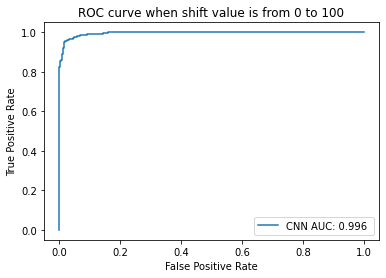

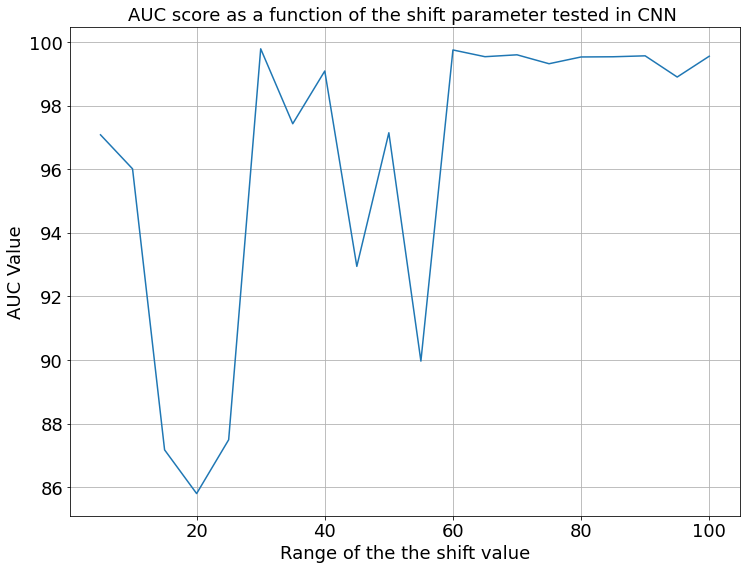

In [13]:
import tqdm
from tqdm.notebook import tnrange

NUM_EPOCHS = 50
LEARNING_RATE =0.01

def plot_accVsshift(x, y, ylbl='AUC Value'):
    fntSize = 18
    plt.figure(figsize=(12, 9))
    plt.plot(np.array(x), np.array(y)*100)
    plt.grid()
    plt.title("AUC score as a function of the shift parameter tested in CNN ", fontsize = fntSize)
    plt.xlabel("Range of the the shift value", fontsize = fntSize)
    plt.ylabel(ylbl, fontsize = fntSize)
    plt.xticks(fontsize = fntSize)
    plt.yticks(fontsize = fntSize)
    plt.savefig("AUCvShift_CNN.png",dpi=200)
    plt.show()
    plt.close()
    
def get_roc(bkgdataFile,sigdataFile):
    bkgdata = np.load(bkgdataFile)
    bkg = bkgdata['output'].tolist()
    sigdata = np.load(sigdataFile)
    sig = sigdata['output'].tolist()
    testY = np.array([1]*len(sig) + [0]*len(bkg))
    predY = np.array(sig+bkg)
    auc = roc_auc_score(testY, predY)
    fpr, tpr, thr = roc_curve(testY, predY)
    return fpr,tpr,thr,auc

def rocCurvePlotRNN(sft,fpr_rnn,tpr_rnn,auc_rnn):
    plt.plot(fpr_rnn,tpr_rnn,label="CNN AUC: %.3f "%(auc_rnn))
    plt.title("ROC curve when shift value is from 0 to "+str(sft))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig("ROC_cnn_"+str(sft)+"shift.png",dpi=200)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()    

shiftParams = []
auc_score = []
fpr_value =[]
tpr_value = []
thr_value = []
# sfts = list(range(5, 100, 5)) +list(range(100,330,10))
sfts = list(range(5, 105, 5))
for i in tnrange(len(sfts), desc="Shift"):
    sft = sfts[i]
#     wf_extract(sft, 0)
#     wf_extract(sft, 1)
    run_wf_in_nn(sft)
      # Plot the ROC curve for RNN 
    fpr_cnn, tpr_cnn, thr_cnn, auc_cnn = get_roc("cnn_bkgoutput.npz", "cnn_sigoutput.npz")
    rocCurvePlotRNN(sft,fpr_cnn,tpr_cnn,auc_cnn)
    auc_score.append(auc_cnn)
    shiftParams.append(sft)
    fpr_value.append(fpr_cnn)
    tpr_value.append(tpr_cnn)
    thr_value.append(thr_cnn)
plot_accVsshift(shiftParams,auc_score)

In [14]:
with open("shift_aucScore_cnn.txt", "w") as f:
    f.writelines(map("{},{}\n".format, shiftParams, auc_score))

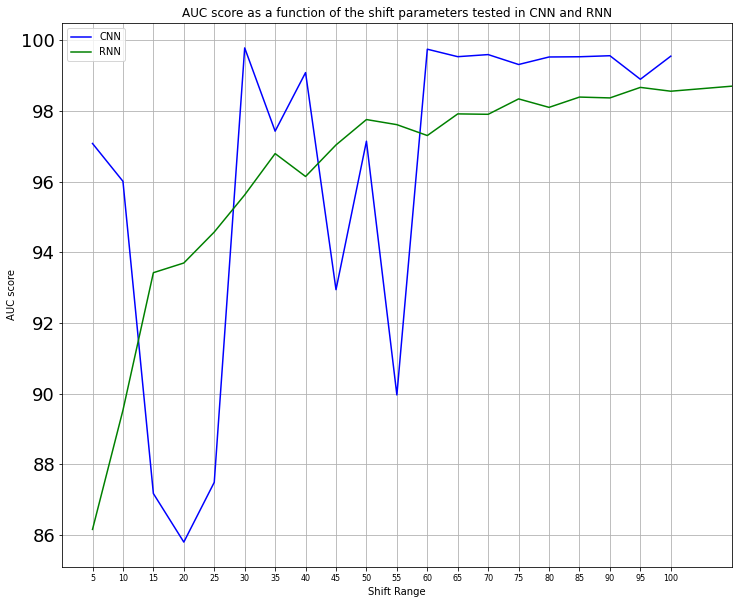

In [15]:
import matplotlib.pyplot as plt
shifts_cnn, aucScores_cnn = np.loadtxt('shift_aucScore_cnn.txt', delimiter=',', unpack=True)
shifts_rnn, aucScores_rnn = np.loadtxt('shift_aucScore_rnn.txt', delimiter=',', unpack=True)
plt.figure(figsize = (12,10))
plt.plot(shifts_cnn, aucScores_cnn*100,label = "CNN", color = "b")
plt.plot(shifts_rnn,aucScores_rnn*100, label = "RNN",color="g")
plt.grid()
# plt.ylim(85,100)
plt.xlim(0,110)
plt.title("AUC score as a function of the shift parameters tested in CNN and RNN")
plt.xlabel('Shift Range')
plt.ylabel('AUC score')
plt.xticks(shifts_cnn,fontsize=8)
plt.yticks(fontsize=18)
plt.legend()
plt.savefig("RNNandCNN.png")
plt.show()